In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import linen as nn
import jax
import haiku as hk
from flax.linen import MultiHeadDotProductAttention
import jax.tree_util as tree
import models_utils as mu
from einshape import jax_einshape as einshape



In [2]:
class MLP(nn.Module):
  hidden_dim: int
  out_dim: int
  depth: int

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i in range(self.depth):
      x = nn.Dense(features=self.hidden_dim)(x)
      x = nn.gelu(x)
    x = nn.Dense(features=self.out_dim)(x)
    return x


class SelfAttnTransformer(nn.Module):
  n_layers: int
  n_heads: int
  head_dim: int
  model_dim: int # the dimension of the input/output of the attention block and dense block
  widening_factor: int # widening factor for hidden_dim

  @nn.compact
  def __call__(self, inputs, mask = None):
    # self attention transformer
    '''
    inputs: [batch_sizes..., length, features]
    mask: [batch_sizes..., num_heads, query_length, key/value_length], 
          where query_length = key/value_length = length
    '''
    x = inputs # the size of x is kept the same throughout the transformer
    for _ in range(self.n_layers):
      attn_block = MultiHeadDotProductAttention(num_heads = self.n_heads, 
                                                qkv_features = self.head_dim * self.n_heads, 
                                                out_features = self.model_dim)
      x = attn_block(inputs_q = x, inputs_k = x, inputs_v = x, mask = mask) + x
      x = nn.LayerNorm()(x)
      dense_block = MLP(hidden_dim = self.model_dim * self.widening_factor, 
                        out_dim = self.model_dim, 
                        depth = 1)
      x = dense_block(x) + x
      x = nn.LayerNorm()(x)
    
    return x


In [3]:
# demonstrate the self-attention transformer, also show how Jax + Flax works
bs = 10
model_dim = 256 # input/output dimension of the transformer
sequence_length = 32
n_layers = 2
n_heads = 8
head_dim = 64
widening_factor = 4

transformer_model = SelfAttnTransformer(n_layers = n_layers, 
                            n_heads = n_heads, 
                            head_dim = head_dim, 
                            model_dim = model_dim, 
                            widening_factor = widening_factor)
subkey1, subkey2 = jax.random.split(jax.random.PRNGKey(0))
rngs = {'params': subkey1, 'dropout': subkey2}

inputs = jnp.ones((bs, sequence_length, model_dim))
params = transformer_model.init(rngs, inputs)

@jax.jit
def transformer_forward_fn(params, rng_key, data):
  # rngs is useless here since the model doesn't have dropout or other random operations
  return transformer_model.apply(params, data, rngs = {'dropout':rng_key}) 

# forward pass
rng_gen = hk.PRNGSequence(42) # hk.PRNGSequence is a convenient way to generate random keys
out = transformer_forward_fn(params, next(rng_gen), inputs)
print(out.shape) # (bs, sequence_length, model_dim)


2024-05-03 01:37:47.195397: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(10, 32, 256)


In [4]:
from collections import namedtuple
Data = namedtuple('Data', ['demo_cond_k', 'demo_cond_v', 'demo_cond_mask', 
                          'demo_qoi_k', 'demo_qoi_v', 'demo_qoi_mask',
                          'quest_cond_k', 'quest_cond_v', 'quest_cond_mask',
                          'quest_qoi_k', 'quest_qoi_mask',])
'''
data, named tuple, with the following field:
  demo_cond_k: [demo_num, demo_cond_len, cond_k_dim]
  demo_cond_v: [demo_num, demo_cond_len, cond_v_dim]
  demo_cond_mask: [demo_num, demo_cond_len]
  demo_qoi_k: [demo_num, demo_qoi_len, qoi_k_dim]
  demo_qoi_v: [demo_num, demo_qoi_len, qoi_v_dim]
  demo_qoi_mask: [demo_num, demo_qoi_len]
  quest_cond_k: [1, quest_cond_len, cond_k_dim]
  quest_cond_v: [1, quest_cond_len, cond_v_dim]
  quest_cond_mask: [1, quest_cond_len]
  quest_qoi_k: [1, quest_qoi_len, qoi_k_dim]
  quest_qoi_v: [1, quest_qoi_len, qoi_v_dim] # this is the ground truth, actually excluded in data
  quest_qoi_mask: [1, quest_qoi_len] 
'''

# this is also the shape of the data in the ICON-LM paper, except no batch dimensions
test_data = Data(demo_cond_k = np.ones((5, 50, 1)), # 5 examples, 50 tokens, 1 features (x)
                  demo_cond_v = np.ones((5, 50, 1)), # 5 examples, 50 tokens, 1 feature (value)
                  demo_cond_mask = np.ones((5, 50)).astype(bool), # 5 examples, 50 tokens
                  demo_qoi_k = np.ones((5, 50, 1)),
                  demo_qoi_v = np.ones((5, 50, 1)),
                  demo_qoi_mask = np.ones((5, 50)).astype(bool),
                  quest_cond_k = np.ones((1, 50, 1)), # 1 question, 50 tokens, 1 features (x)
                  quest_cond_v = np.ones((1, 50, 1)),  # 1 question, 50 tokens, 1 feature (value)
                  quest_cond_mask = np.ones((1, 50)).astype(bool),  # 1 question, 50 tokens
                  quest_qoi_k = np.ones((1, 50, 1)),
                  quest_qoi_mask = np.ones((1, 50)).astype(bool)
                  )

In [5]:
def build_matrices_from_data_shape(data_shape, mode, shot_num_min, return_shape_list = False):
  '''
  data_shape is the shape of data, usually obtained by tree.tree_map(lambda x: x.shape, data)
  '''
  demo_num = data_shape.demo_cond_k[0]
  demo_cond_len = data_shape.demo_cond_k[1]
  demo_qoi_len = data_shape.demo_qoi_k[1]
  quest_cond_len = data_shape.quest_cond_k[1]
  quest_qoi_len = data_shape.quest_qoi_k[1]

  cond_bool_list, qoi_kv_bool_list, qoi_k_bool_list = mu.build_bool_sequence(demo_num, mode, shot_num_min)
  cond_len_list_raw = [demo_cond_len] * demo_num + [quest_cond_len]
  qoi_kv_len_list_raw = [demo_qoi_len] * demo_num + [quest_qoi_len]
  qoi_k_len_list_raw = [demo_qoi_len] * demo_num + [quest_qoi_len]
  cond_len_list = [i * j for i, j in zip(cond_bool_list, cond_len_list_raw)]
  qoi_kv_len_list = [i * j for i, j in zip(qoi_kv_bool_list, qoi_kv_len_list_raw)]
  qoi_k_len_list = [i * j for i, j in zip(qoi_k_bool_list, qoi_k_len_list_raw)]
  
  basic_mask = mu.build_basic_mask(cond_len_list = cond_len_list, 
                                qoi_kv_len_list = qoi_kv_len_list, 
                                qoi_k_len_list = qoi_k_len_list)
  index_pos = mu.build_index_integer(cond_len_list= cond_len_list,
                                      qoi_kv_len_list = qoi_kv_len_list,
                                      qoi_k_len_list = qoi_k_len_list)
  out_mask = mu.build_out_mask(cond_len_list = cond_len_list,
                          qoi_kv_len_list= qoi_kv_len_list,
                          qoi_k_len_list = qoi_k_len_list,
                          num_range = (shot_num_min, demo_num + 1))

  
  if return_shape_list:
    return basic_mask, index_pos, out_mask, cond_len_list, qoi_kv_len_list, qoi_k_len_list
  else:
    return basic_mask, index_pos, out_mask

Data(demo_cond_k=(5, 50, 1), demo_cond_v=(5, 50, 1), demo_cond_mask=(5, 50), demo_qoi_k=(5, 50, 1), demo_qoi_v=(5, 50, 1), demo_qoi_mask=(5, 50), quest_cond_k=(1, 50, 1), quest_cond_v=(1, 50, 1), quest_cond_mask=(1, 50), quest_qoi_k=(1, 50, 1), quest_qoi_mask=(1, 50))
[50, 50, 50, 50, 50, 50] [50, 50, 50, 50, 50, 0] [50, 50, 50, 50, 50, 50]


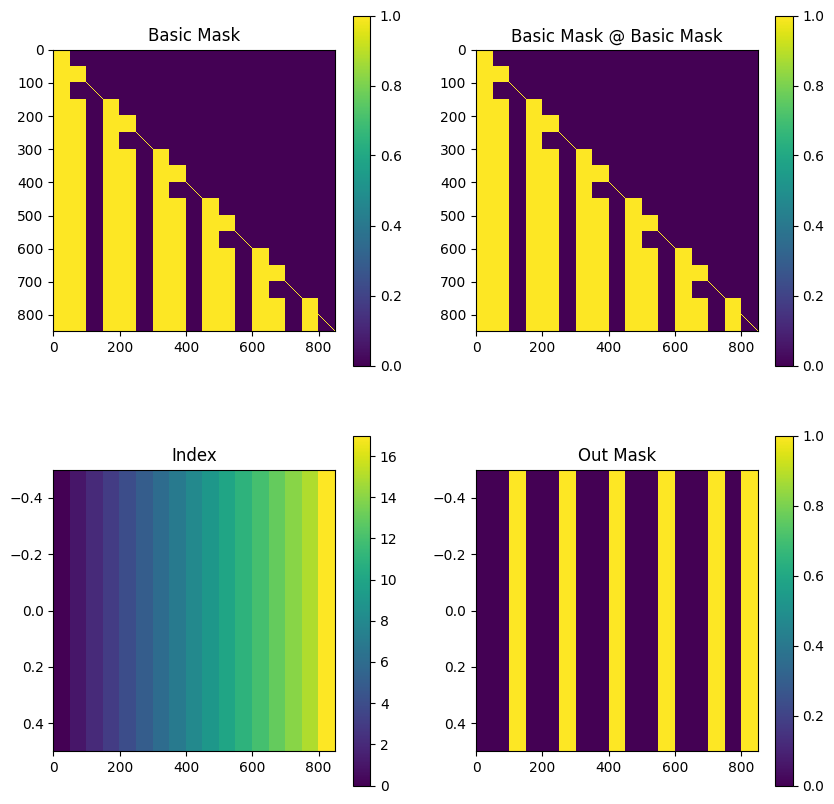

In [6]:
data_shape = tree.tree_map(lambda x: x.shape, test_data)
print(data_shape)

basic_mask, index_pos, out_mask, cond_len_list, qoi_kv_len_list, qoi_k_len_list = \
    build_matrices_from_data_shape(data_shape, 'train', 0, return_shape_list = True)

print(cond_len_list, qoi_kv_len_list, qoi_k_len_list)
# [50, 50, 50, 50, 50, 50] [50, 50, 50, 50, 50, 0] [50, 50, 50, 50, 50, 50] 
fig = mu.plot_model_consts(basic_mask, index_pos[:,None], out_mask)
plt.show()


[50, 50, 50, 50, 50, 50] [50, 50, 50, 50, 50, 0] [0, 0, 0, 0, 0, 50]


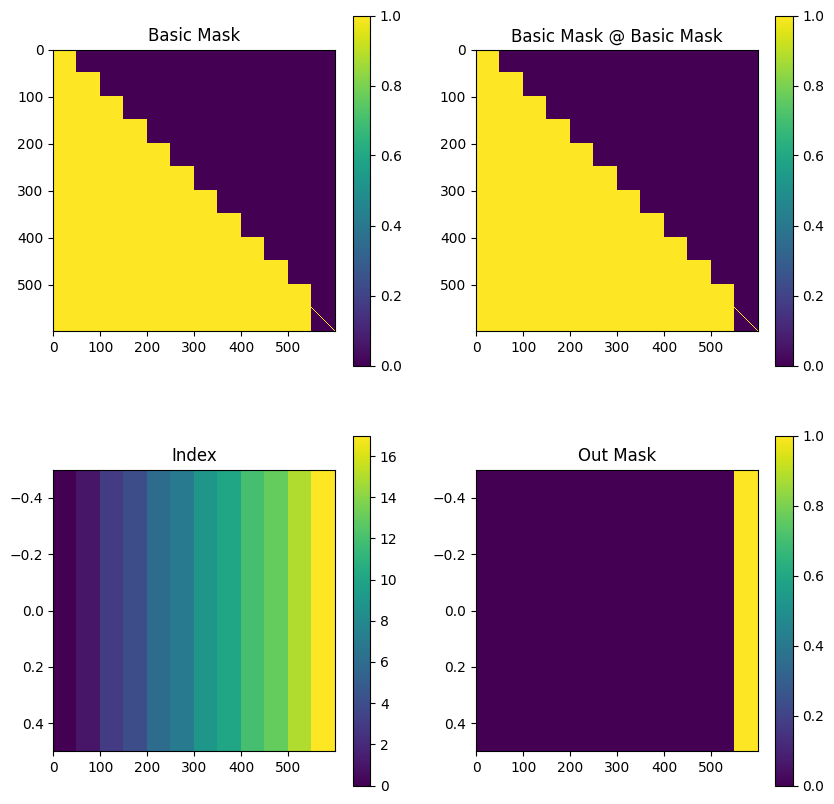

In [7]:
basic_mask, index_pos, out_mask, cond_len_list, qoi_kv_len_list, qoi_k_len_list = \
    build_matrices_from_data_shape(data_shape, 'test', 0, return_shape_list = True)

print(cond_len_list, qoi_kv_len_list, qoi_k_len_list)
# [50, 50, 50, 50, 50, 50] [50, 50, 50, 50, 50, 0] [0, 0, 0, 0, 0, 50]
fig = mu.plot_model_consts(basic_mask, index_pos[:,None], out_mask)
plt.show()


token sequence:
i: term, t: time, s: space, v: value

Here are the tokens for one example:
```
                Condition_j              |                    QOI_j              |             Query_j
cond_j_i_1, cond_j_i_2, ..., cond_j_i_50,| qoi_j_i_1, qoi_j_i_2, ..., qoi_j_i_50,| qoi_j_i_1, qoi_j_i_2, ..., qoi_j_i_50,
cond_j_t_1, cond_j_t_2, ..., cond_j_t_50,| qoi_j_t_1, qoi_j_t_2, ..., qoi_j_t_50,| qoi_j_t_1, qoi_j_t_2, ..., qoi_j_t_50,
cond_j_s_1, cond_j_s_2, ..., cond_j_s_50,| qoi_j_s_1, qoi_j_s_2, ..., qoi_j_s_50,| qoi_j_s_1, qoi_j_s_2, ..., qoi_j_s_50,
cond_j_v_1, cond_j_v_2, ..., cond_j_v_50,| qoi_j_v_1, qoi_j_v_2, ..., qoi_j_v_50,|    0     ,    0     , ...,    0      , 
```
The first 3 rows are the k, the last row is the v

The whole sequence is: 
```
Condition_1, QoI_1, Query_1, Condition_2, QoI_2, Query_2, ..., Condition_n, QoI_n, Query_n
```
Some subsequences should be dropped during training or testing, which is controled by `cond_len_list`, `qoi_kv_len_list`, `qoi_k_len_list`


In [8]:
class ICON_LM(nn.Module):

  config: dict
  # these matrices are constant, so we can pre-compute them.
  basic_mask: jnp.ndarray # [x, x] the mask designed for ICON-LM
  index_pos: jnp.ndarray # [x] the index for positional embedding
  out_mask: jnp.ndarray # [x]
  
  def setup(self):

    self.pre_projection = nn.Dense(self.config['transformer']['model_dim'], name="pre_projection")
    # trainable positional embedding
    self.func_pos_embedding = nn.Embed((self.config['demo_max_num']) * 3, self.config['transformer']['model_dim'], name="func_pos_embedding")
    self.transformer = SelfAttnTransformer(**(self.config['transformer']), name='transformer')
    self.post_projection = nn.Dense(self.config['out_dim'], name="post_projection")

  def basic_forward(self, data, mode, index_pos, basic_mask):

    demo_num = len(data.demo_cond_k)
    cond_bool_list, qoi_kv_bool_list, qoi_k_bool_list = mu.build_bool_sequence(demo_num, mode = mode, shot_num_min = 0)
    sequence = mu.build_data_sequence(data, cond_bool_list, qoi_kv_bool_list, qoi_k_bool_list)
    mask = mu.build_data_mask(data, cond_bool_list, qoi_kv_bool_list, qoi_k_bool_list)
    
    sequence = self.pre_projection(sequence)
    sequence = sequence + self.func_pos_embedding(index_pos)

    mask = einshape('i->ji', mask, j = sequence.shape[0])
    mask = mask * basic_mask
    mask = einshape("ij->mij", mask, m = self.config['transformer']['n_heads']) 
    sequence = self.transformer(sequence, mask = mask)
    sequence = self.post_projection(sequence)
    return sequence
  
  def __call__(self, data): 
    '''
    this is for standard forward, using pre-computed matrices
    used for training, predict all the QoIs based on previous examples and the current condition
    '''
    sequence = self.basic_forward(data, 'train', self.index_pos, self.basic_mask)
    sequence = sequence[self.out_mask] # [num * qoi_len, out_dim]
    return sequence

  def predict(self, data):
    '''
    this is for flexible data shape, will build basic mask, index, and out mask on the fly,
    used for testing, predict the last QoI, i.e. the question QoI
    '''
    data_shape = tree.tree_map(lambda x: x.shape, data)
    basic_mask, index_pos, out_mask = build_matrices_from_data_shape(data_shape, mode = 'test', shot_num_min = 0)
    sequence = self.basic_forward(data, 'test', index_pos, basic_mask)
    sequence = sequence[-data.quest_qoi_mask.shape[-1]:,:] # [quest_qoi_len, out_dim]
    return sequence


In [9]:
model_config = {"demo_max_num": 6,
                "index_mode": "learn",
                "transformer": {"n_layers":6,
                                "n_heads":8, 
                                "head_dim":256, 
                                "model_dim":256, 
                                "widening_factor": 4, 
                              },
                "out_dim": 1
              }


In [10]:
basic_mask, index_pos, out_mask = build_matrices_from_data_shape(data_shape,  mode = 'train', shot_num_min = 0)
icon_lm_model = ICON_LM(model_config, basic_mask = basic_mask, index_pos = index_pos, out_mask = out_mask)
subkey1, subkey2 = jax.random.split(jax.random.PRNGKey(0))
rngs = {'params': subkey1, 'dropout': subkey2}
params = icon_lm_model.init(rngs, test_data)

@jax.jit
def icon_lm_forward_fn(params, rng_key, data):
  # rngs is useless here since the model doesn't have dropout or other random operations
  return icon_lm_model.apply(params, data, rngs = {'dropout':rng_key}) 

@jax.jit
def icon_lm_predict_fn(params, rng_key, data):
  # rngs is useless here since the model doesn't have dropout or other random operations
  return icon_lm_model.apply(params, data, rngs = {'dropout':rng_key}, method = "predict") 

# forward pass
rng_gen = hk.PRNGSequence(42) # hk.PRNGSequence is a convenient way to generate random keys
out = icon_lm_forward_fn(params, next(rng_gen), test_data)
print(out.shape) # (sequence_length, out_dim), where sequence_length = num * qoi_len = (5+1) * 50 = 300

# predict pass
out = icon_lm_predict_fn(params, next(rng_gen), test_data)
print(out.shape) # (quest_qoi_len, out_dim), where quest_qoi_len = 50

(300, 1)
(50, 1)


Note: Until now, everyting has no batch dimension. This is the character of jax: we build the function without batch dimension, and then we can use `vmap` to add batch dimension.

In [11]:
icon_lm_forward_fn_batch = jax.jit(jax.vmap(icon_lm_forward_fn, in_axes = (None, None, 0)))
icon_lm_predict_fn_batch = jax.jit(jax.vmap(icon_lm_predict_fn, in_axes = (None, None, 0)))

In [12]:
file_name = "Poisson_PDE_data"
raw_data = np.load(f'./{file_name}.npy')
print(raw_data.shape)

(20, 6, 2, 101, 2)


Build prompt and labels for training

In [13]:
bs = len(raw_data)
data = Data(demo_cond_k = raw_data[:,:5,0,1:-1:2,0:1], # (bs = 20, examples = 5, tokens = 50, kdim = 1) 
            demo_cond_v = raw_data[:,:5,0,1:-1:2,1:2], # (bs = 20, examples = 5, tokens = 50, vdim = 1)
            demo_cond_mask = np.ones((bs, 5, 50)).astype(bool), # (bs = 20, examples = 5, tokens = 50)
            demo_qoi_k = raw_data[:,:5,1,1:-1:2,0:1], # (bs = 20, examples = 5, tokens = 50, kdim = 1)
            demo_qoi_v = raw_data[:,:5,1,1:-1:2,1:2], # (bs = 20, examples = 5, tokens = 50, vdim = 1)
            demo_qoi_mask = np.ones((bs, 5, 50)).astype(bool), # (bs = 20, examples = 5, tokens = 50)
            quest_cond_k = raw_data[:,5:6,0,1:-1:2,0:1], # (bs = 20, 1, tokens = 50, kdim = 1)
            quest_cond_v = raw_data[:,5:6,0,1:-1:2,1:2], # (bs = 20, 1, tokens = 50, vdim = 1)
            quest_cond_mask = np.ones((bs, 1, 50)).astype(bool),  # (bs = 20, 1, tokens = 50)
            quest_qoi_k = raw_data[:,5:6,1,1:-1:2,0:1], # (bs = 20, 1, tokens = 1, kdim = 1)
            quest_qoi_mask = np.ones((bs, 1, 50)).astype(bool)
                  )
label = raw_data[:,-1,1,1:-1:2,1:2] # (bs = 20, 1, tokens = 1, vdim = 1)

print(tree.tree_map(lambda x: x.shape, data))
print(label.shape)

Data(demo_cond_k=(20, 5, 50, 1), demo_cond_v=(20, 5, 50, 1), demo_cond_mask=(20, 5, 50), demo_qoi_k=(20, 5, 50, 1), demo_qoi_v=(20, 5, 50, 1), demo_qoi_mask=(20, 5, 50), quest_cond_k=(20, 1, 50, 1), quest_cond_v=(20, 1, 50, 1), quest_cond_mask=(20, 1, 50), quest_qoi_k=(20, 1, 50, 1), quest_qoi_mask=(20, 1, 50))
(20, 50, 1)


In [14]:
out = icon_lm_forward_fn_batch(params, next(rng_gen), data)
out.shape


(20, 300, 1)